In [3]:
#Dataset
DATA_PATH = "/mnt/data/credit_risk_dataset.csv"

In [18]:
#Imports and data loading
!pip install shap
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score
from xgboost import XGBClassifier


   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/72.0 MB 1.8 MB/s eta 0:00:40
    --------------------------------------- 1.6/72.0 MB 2.3 MB/s eta 0:00:31
   - -------------------------------------- 2.6/72.0 MB 3.0 MB/s eta 0:00:24
   - -------------------------------------- 3.4/72.0 MB 3.1 MB/s eta 0:00:22
   -- ------------------------------------- 4.5/72.0 MB 3.4 MB/s eta 0:00:20
   -- ------------------------------------- 5.2/72.0 MB 3.7 MB/s eta 0:00:19
   --- ------------------------------------ 6.0/72.0 MB 3.6 MB/s eta 0:00:19
   --- ------------------------------------ 6.8/72.0 MB 3.6 MB/s eta 0:00:18
   ---- --------------------------

In [14]:
#Data processing
df = pd.read_csv("C:\Windows\System32\credit_risk_dataset.csv")

# Drop duplicates, handle missing
df = df.drop_duplicates()
df = df.fillna(df.median(numeric_only=True))

# Separate features X and target y
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

# Identify categorical and numeric columns from X
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()

# Preprocessing pipeline
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

In [19]:
#Train Model
model = XGBClassifier(
    max_depth=5,
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    eval_metric="logloss"
)

pipeline = Pipeline(steps=[
    ("prep", preprocess),
    ("model", model)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

pipeline.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file']),
                                                 ('num', 'passthrough',
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length'])])),
                ('model',
                 XG...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [20]:
#Evaluate Metrices
pred_proba = pipeline.predict_proba(X_test)[:,1]
pred = (pred_proba > 0.5).astype(int)

auc = roc_auc_score(y_test, pred_proba)
f1 = f1_score(y_test, pred)

print("AUC:", auc)
print("F1:", f1)


AUC: 0.9461167897055195
F1: 0.8363988383349468


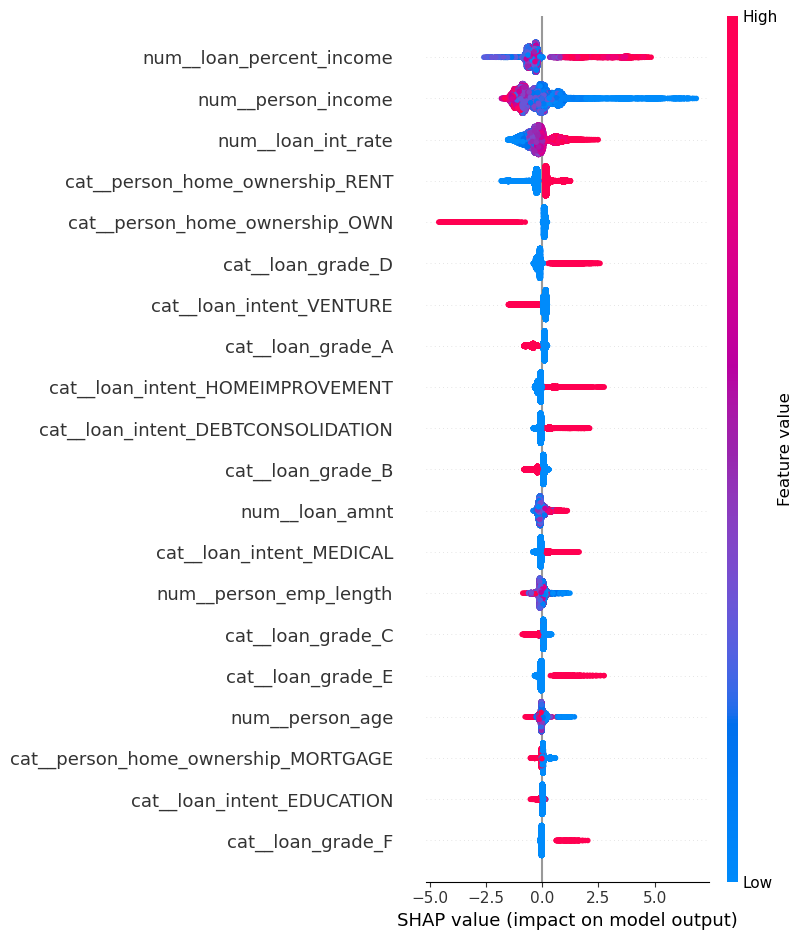

In [21]:
#SHAP Global Explanation
# Get training matrix after OHE
X_train_transformed = pipeline.named_steps["prep"].transform(X_train)

explainer = shap.TreeExplainer(
    pipeline.named_steps["model"],
    feature_perturbation="tree_path_dependent"
)

shap_values = explainer.shap_values(X_train_transformed)

feature_names = (
    pipeline.named_steps["prep"]
    .get_feature_names_out()
)

# Global summary plot
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)

In [22]:
#Select 3 specific customers
test_df = X_test.copy()
test_df["prob"] = pred_proba

high_approval = test_df.sort_values("prob", ascending=False).iloc[0]
high_denial = test_df.sort_values("prob", ascending=True).iloc[0]
borderline = test_df.iloc[(test_df["prob"]-0.5).abs().argsort()].iloc[0]

selected_cases = {
    "high_approval": high_approval,
    "high_denial": high_denial,
    "borderline": borderline
}


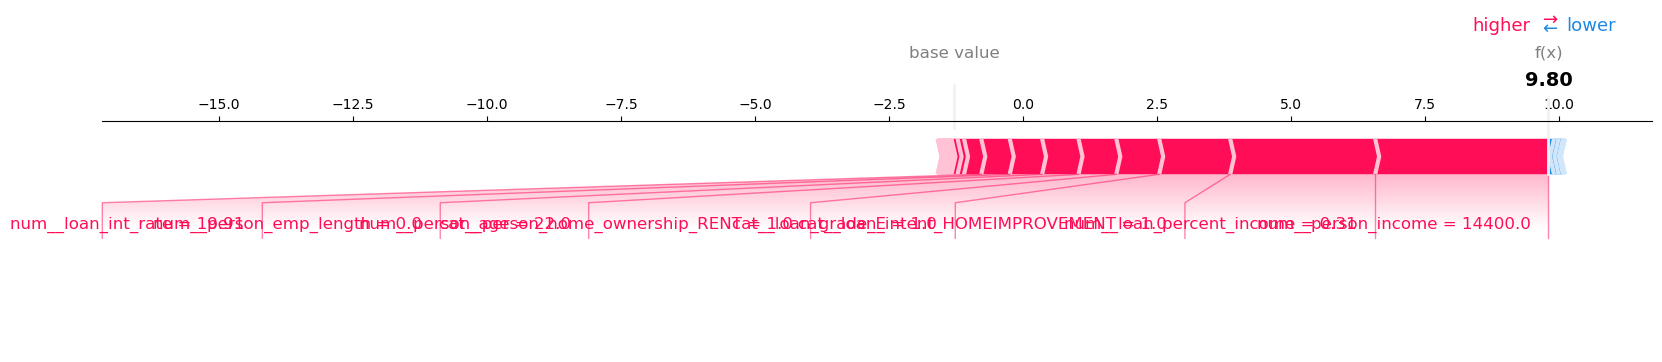

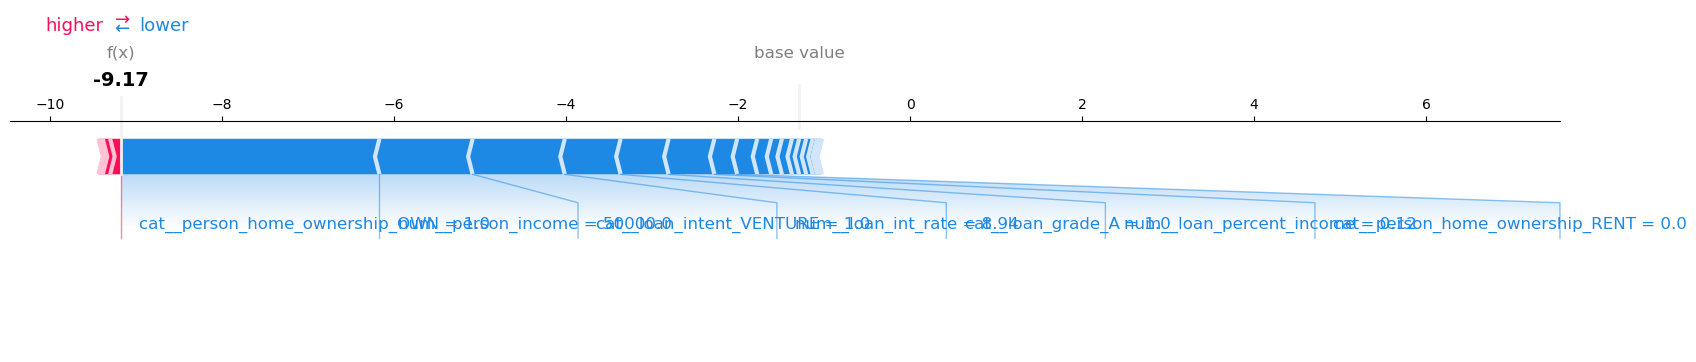

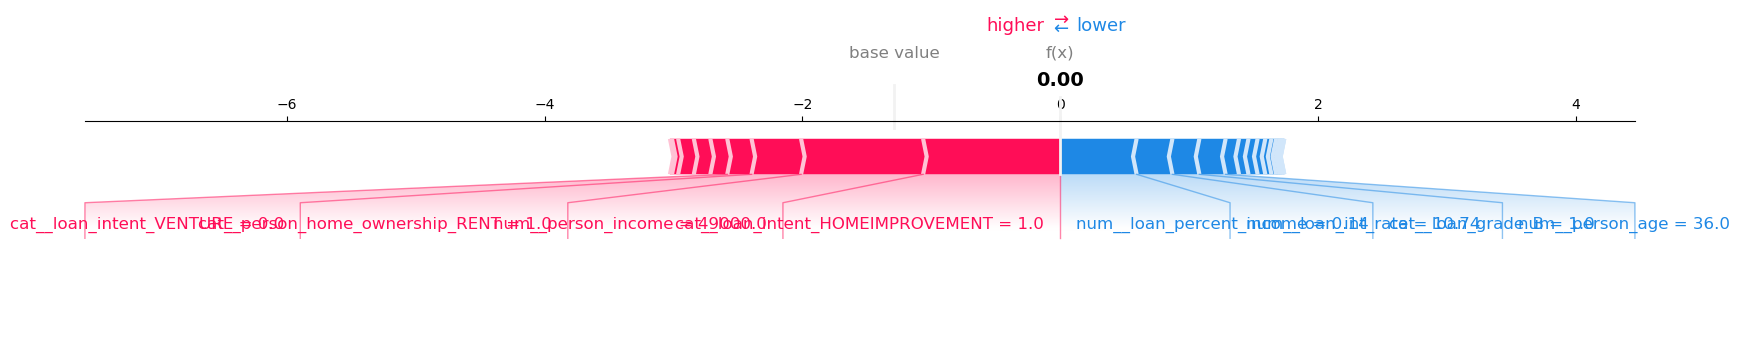

In [23]:
#Local SHAP Force plots
for name, row in selected_cases.items():
    # Ensure x is a DataFrame for the ColumnTransformer
    x = pd.DataFrame([row.drop("prob").to_dict()])

    transformed = pipeline.named_steps["prep"].transform(x)

    sv = explainer.shap_values(transformed)

    shap.force_plot(
        explainer.expected_value,
        sv,
        transformed,
        feature_names=feature_names,
        matplotlib=True,
        show=True
    )